# Static maps

Over the course of the last weeks, we have already become familiar with plotting
basic static maps using
[`geopandas.GeoDataFrame.plot()`](http://geopandas.org/mapping.html), for
instance in lessons [2](../lesson-2/geopandas-an-introduction),
[3](../lesson-3/spatial-join), and [4](../lesson-4/reclassifying-data). We also
learned that `geopandas.GeoDataFrame.plot()` uses the `matplotlib.pyplot`
library, and that [most of its arguments and options are accepted by
geopandas](https://matplotlib.org/stable/api/pyplot_summary.html).

To refresh our memory about the basics of plotting maps, let's create a static
accessibility map of the Helsinki metropolitan area, that also shows roads and
metro lines (three layers, overlaid onto each other). Remember that the input
data sets need to be in the same coordinate system!


## Data

We will use three different data sets:
- the travel time to the Helsinki railway station we used in [lesson
  4](../lesson-4/reclassifying-data), which is in `DATA_DIRECTORY /
"helsinki_region_travel_times_to_railway_station"`,
- the Helsinki Metro network, available via WFS from the city's map services,
  and
- a simplified network of the most important roads in the metropolitan region,
  also available via WFS from the same endpoint.


In [1]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [2]:
import geopandas
import numpy
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

accessibility_grid = geopandas.read_file(
    DATA_DIRECTORY
    / "helsinki_region_travel_times_to_railway_station"
    / "helsinki_region_travel_times_to_railway_station.gpkg"
)
accessibility_grid["pt_r_t"] = accessibility_grid["pt_r_t"].replace(-1, numpy.nan)

WFS_BASE_URL = (
    "https://kartta.hel.fi/ws/geoserver/avoindata/wfs"
    "?service=wfs"
    "&version=2.0.0"
    "&request=GetFeature"
    "&srsName=EPSG:3879"
    "&typeName={layer:s}"
)

metro = (
    geopandas.read_file(
        WFS_BASE_URL.format(layer="avoindata:Seutukartta_liikenne_metro_rata")
    )
    .set_crs("EPSG:3879")
)
roads = (
    geopandas.read_file(
        WFS_BASE_URL.format(layer="avoindata:Seutukartta_liikenne_paatiet")
    )
    .set_crs("EPSG:3879")
)

> **Attention: Coordinate Reference Systems**
>
> Remember that different geo-data frames need to be in the same coordinate system
> before plotting them in the same map. `geopandas.GeoDataFrame.plot()` does not
> reproject data automatically.
>
> You can always check it with a simple `assert` statement.


In [3]:
assert accessibility_grid.crs == metro.crs == roads.crs, "Input data sets’ CRS differs"

AssertionError: Input data sets’ CRS differs

If multiple data sets do not share a common CRS, first, figure out which CRS
they have assigned (if any!), then transform the data into a common reference
system:

In [4]:
print(accessibility_grid.crs)

EPSG:3067


In [5]:
print(metro.crs)

EPSG:3879


In [6]:
print(roads.crs)

EPSG:3879


In [7]:
roads = roads.to_crs(accessibility_grid.crs)
metro = metro.to_crs(accessibility_grid.crs)

In [8]:
assert accessibility_grid.crs == metro.crs == roads.crs, "Input data sets’ CRS differs"

## Plotting a multi-layer map

> **Hint: Check Your Understanding**
>
> Complete the next steps at your own pace (clear out the code cells first).
> Make sure to revisit previous lessons if you feel unsure how to complete
> a task.
>
> - Visualize a multi-layer map using the `geopandas.GeoDataFrame.plot()` method;
> - First, plot the accessibility grid using a ‘quantiles’ classification scheme;
> - Then, add roads network and metro lines in the same plot (remember the `ax` parameter).



Remember the following options that can be passed to `plot()`:
- style the polygon layer:
    - define a classification scheme using the `scheme` parameter
    - [change the colour map using
      `cmap`](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
    - control the layer’s transparency the `alpha` parameter (`0` is fully
      transparent, `1` fully opaque)
- style the line layers:
    - adjust [the line
      colour](https://matplotlib.org/stable/api/colors_api.html) using the
      `color` parameter
    - change the `linewidth`, as needed

The layers have different extents (`roads` covers a much larger area). You can
use the axes’ (`ax`) methods `set_xlim()` and `set_ylim()` to set the horizontal
and vertical extents of the map (e.g., to a geo-data frame’s `total_bounds`).

(6665250.00004393, 6698000.000038021)

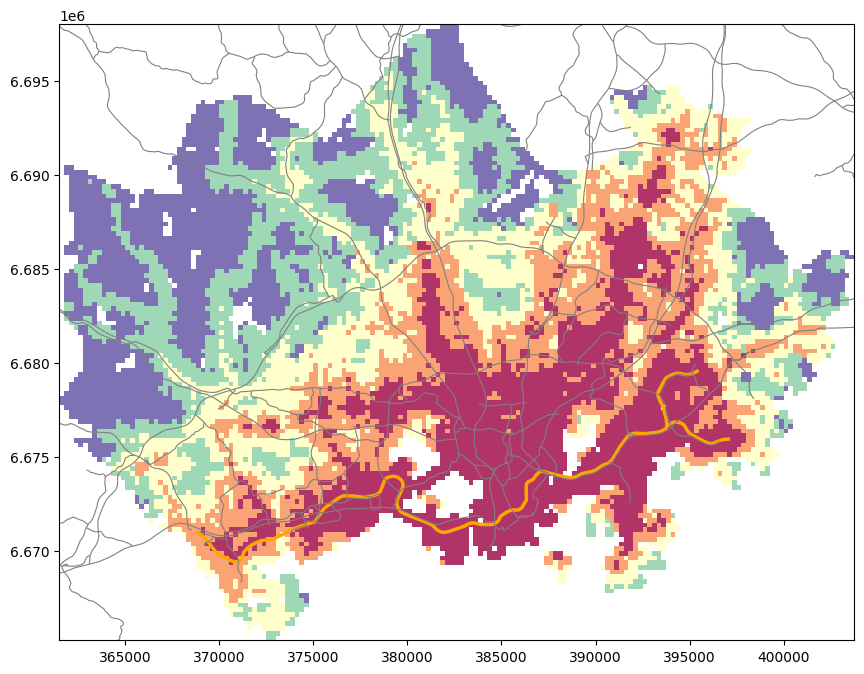

In [9]:
import matplotlib.pyplot as plt
ax = accessibility_grid.plot(
    figsize=(12, 8),

    column="pt_r_t",
    scheme="quantiles",
    cmap="Spectral",
    linewidth=0,
    alpha=0.8
)

metro.plot(
    ax=ax,
    color="orange",
    linewidth=2.5
)

roads.plot(
    ax=ax,
    color="grey",
    linewidth=0.8
)

minx, miny, maxx, maxy = accessibility_grid.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

![Accessibility grid plot](maps/accessibility_plot.jpg)

## Adding a legend

To plot a legend for a map, add the `legend=True` parameter.

For figures without a classification `scheme`, the legend consists of a colour
gradient bar. The legend is an instance of
[`matplotlib.pyplot.colorbar.Colorbar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html),
and all arguments defined in `legend_kwds` are passed through to it. See below
how to use the `label` property to set the *legend title*:

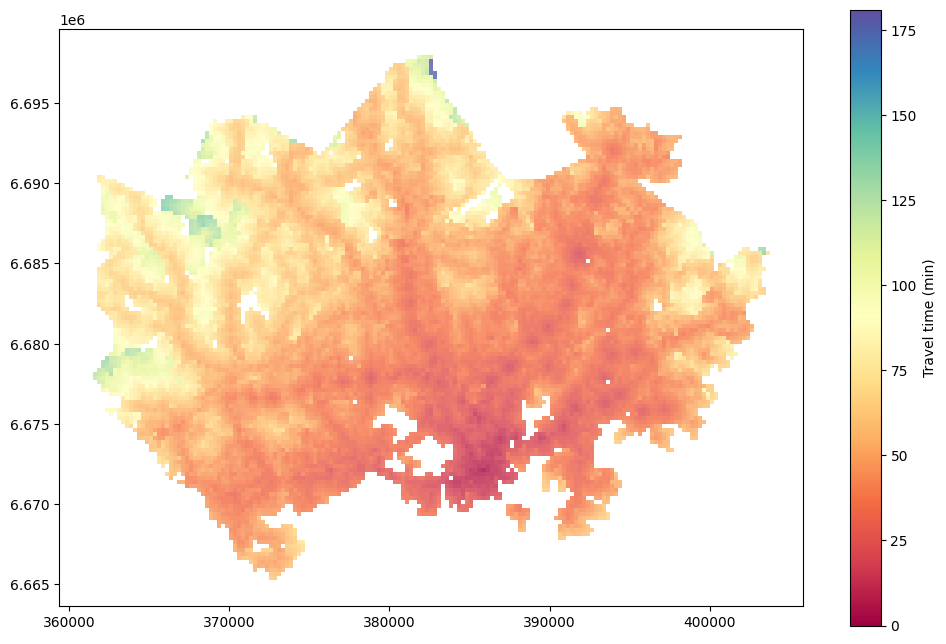

In [10]:
ax = accessibility_grid.plot(
    figsize=(12, 8),

    column="pt_r_t",
    cmap="Spectral",
    linewidth=0,
    alpha=0.8,

    legend=True,
    legend_kwds={"label": "Travel time (min)"}
)

![Accessibility grid plot](maps/accessibility_plot_leg.jpg)

> **Hint: Set Other `Colorbar` Parameters**
>
> Check out [`matplotlib.pyplot.colorbar.Colorbar`’s documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html)
> and experiment with other parameters! Anything you add to the `legend_kwds` dictionary will be passed to the color bar.



---


For figures that use a classification `scheme`, on the other hand, `plot()`
creates a
[`matplotlib.legend.Legend`](https://matplotlib.org/stable/api/legend_api.html#matplotlib.legend.Legend).
Again, `legend_kwds` are passed through, but the parameters are slightly
different: for instance, use `title` instead of `label` to set the legend
title:

<Axes: >

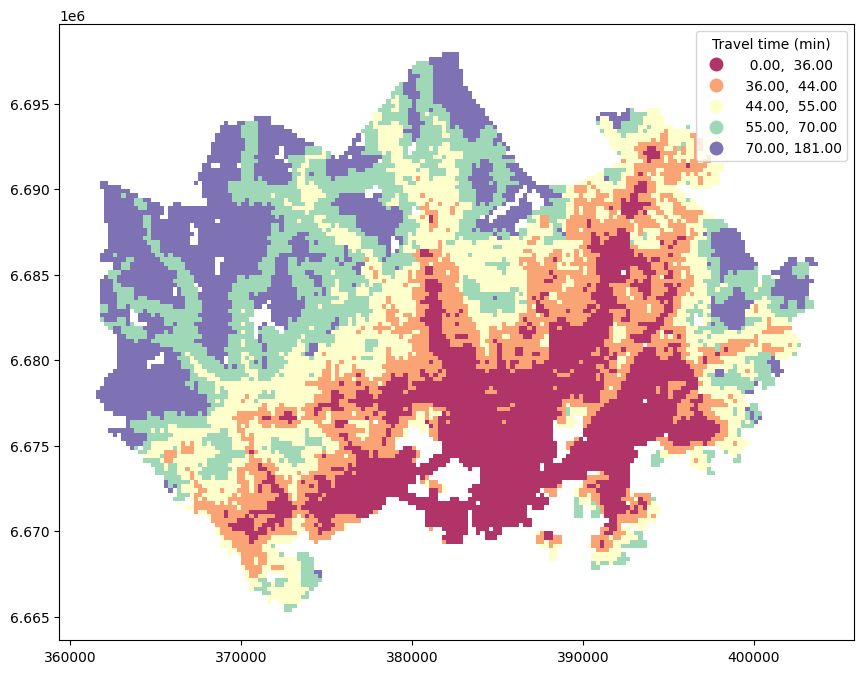

In [11]:
accessibility_grid.plot(
    figsize=(12, 8),

    column="pt_r_t",
    scheme="quantiles",
    cmap="Spectral",
    linewidth=0,
    alpha=0.8,

    legend=True,
    legend_kwds={"title": "Travel time (min)"}
)

> **Hint: Set Other `Legend` Parameters**
>
> Check out [`matplotlib.pyplot.legend.Legend`’s documentation](https://matplotlib.org/stable/api/legend_api.html#matplotlib.legend.Legend), and experiment with other parameters! Anything you add to the `legend_kwds` dictionary will be passed to the legend.
>
> What `legend_kwds` keyword would spread the legend onto two columns?



## Adding a base map

For better orientation, it is often helpful to add a base map to a map plot. A
base map, for instance, from map providers such as
[OpenStreetMap](https://osm.org/) or [Stamen](https://maps.stamen.com/), adds
streets, place names, and other contextual information.

The Python package [contextily](https://contextily.readthedocs.io/) takes care
of downloading the necessary map tiles and rendering them in a geopandas plot.

> **Caution: Web Mercator**
>
> Map tiles from online map providers are typically in [Web Mercator projection (EPSG:3857)](http://spatialreference.org/ref/sr-org/epsg3857-wgs84-web-mercator-auxiliary-sphere/).
> It is generally advisable to transform all other layers to `EPSG:3857`, too.


In [12]:
accessibility_grid = accessibility_grid.to_crs("EPSG:3857")
metro = metro.to_crs("EPSG:3857")
roads = roads.to_crs("EPSG:3857")

To add a base map to an existing plot, use the
[`contextily.add_basemap()`](https://contextily.readthedocs.io/en/latest/intro_guide.html)
function, and supply the plot’s `ax` object obtained in an earlier step.

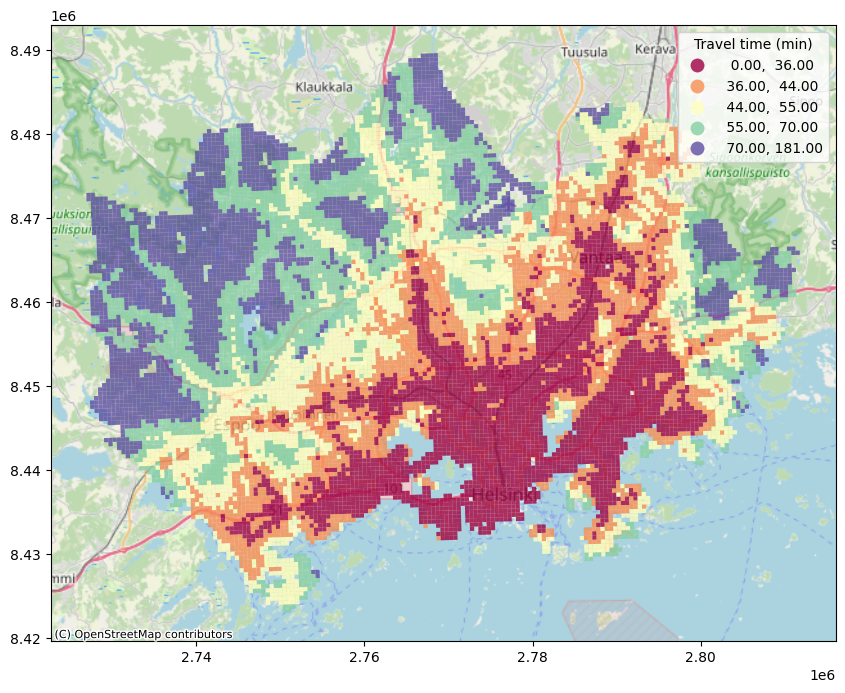

In [13]:
import contextily

ax = accessibility_grid.plot(
    figsize=(12, 8),

    column="pt_r_t",
    scheme="quantiles",
    cmap="Spectral",
    linewidth=0,
    alpha=0.8,

    legend=True,
    legend_kwds={"title": "Travel time (min)"}
)
contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik)

[There are many
other online maps to choose
from](https://contextily.readthedocs.io/en/latest/intro_guide.html#Providers).
Any of the other `contextily.providers` (see link above) can be passed as a
`source` to `add_basemap()`. You can get a list of available providers:

In [14]:
contextily.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://tile.openstreetmap.de/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'html_attribution': '&copy; OpenStreetMap France | &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles style by <a href="https://www.hotosm.org/" target="_blank">Humanitarian OpenStreetMap Team</a> hosted by <a href="https://openstreetmap.fr/" target="_blank">OpenStreetMap France</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France',
   'name': 'OpenStreetMap.HOT'},
  'BZH': {'url': 'https://tile.openstreetmap.bzh/br/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="http://www.openstreetmap.bzh/" target="_blank">Breton OpenStreetMap Team</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
   'bounds': [[46.2, -5.5], [50, 0.7]],
   'name': 'OpenStreetMap.BZH'},
  'BlackAndWhite': {'url': 'http://{s}.tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'name': 'OpenStreetMap.BlackAndWhite'}},
 'MapTilesAPI': {'OSMEnglish': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'en/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMEnglish'},
  'OSMFrancais': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'fr/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMFrancais'},
  'OSMEspagnol': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'es/map/v1',
   'apikey': '<insert 

In this zoom level, the benefits from using OpenStreetMap (such as place names)
do not live to their full potential. Let’s look at a subset of the travel time
matrix: grid cells that are within 15 minutes from the railway station.

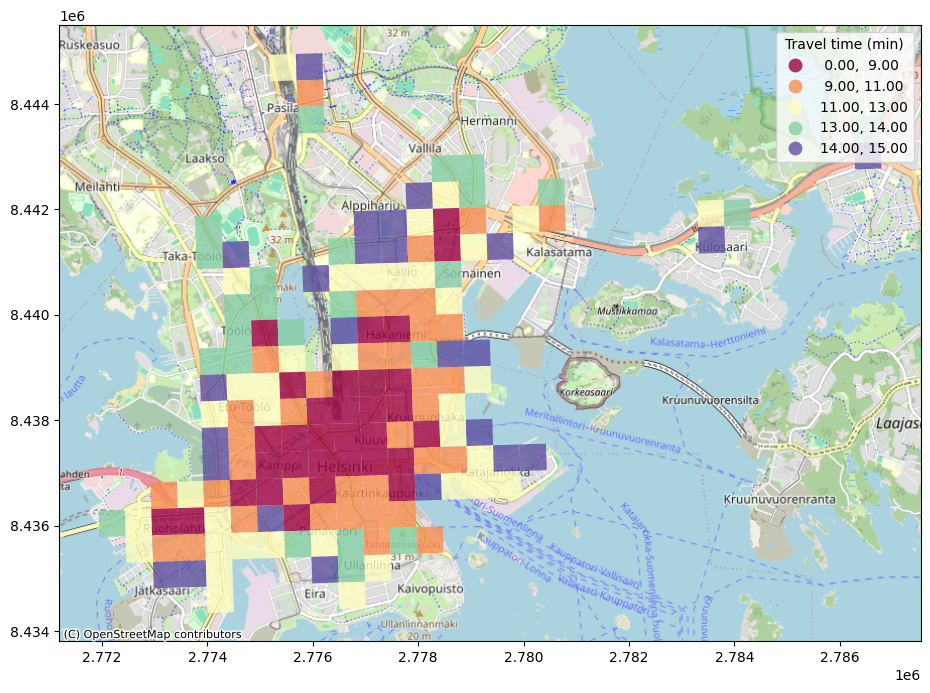

In [15]:
ax = accessibility_grid[accessibility_grid.pt_r_t <= 15].plot(
    figsize=(12, 8),

    column="pt_r_t",
    scheme="quantiles",
    k=5,
    cmap="Spectral",
    linewidth=0,
    alpha=0.8,

    legend=True,
    legend_kwds={"title": "Travel time (min)"}
)
contextily.add_basemap(
    ax,
    source=contextily.providers.OpenStreetMap.Mapnik
)

Finally, we can modify the attribution (copyright notice) displayed in the
bottom left of the map plot. Note that you should *always* respect the map
providers’ terms of use, which typically include a data source attribution
(*contextily*’s defaults take care of this). We can and should, however,
add a data source for any layer we added, such as the travel time matrix
data set:

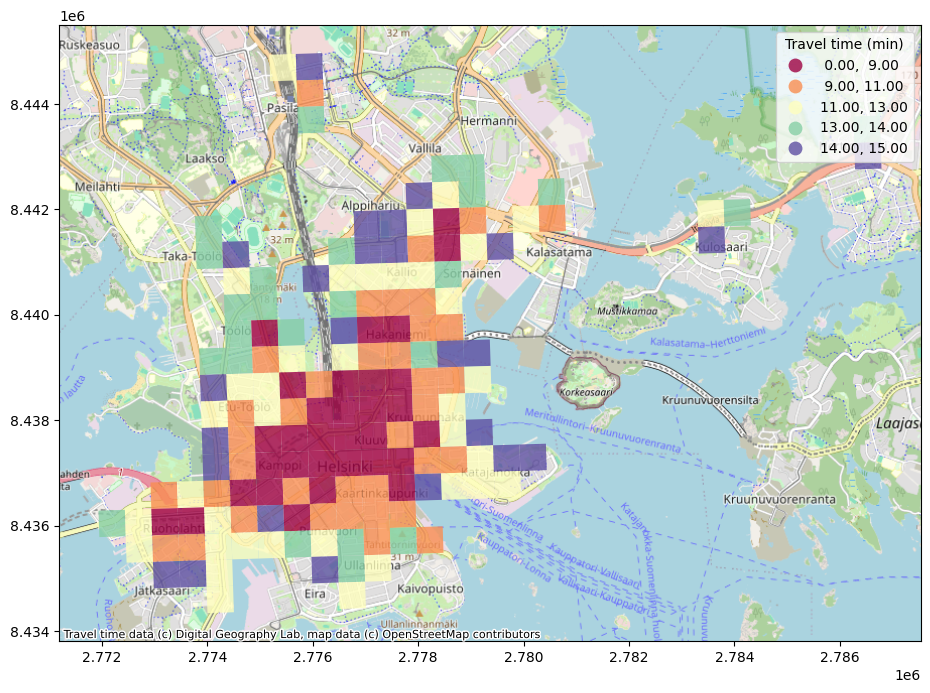

In [16]:
ax = accessibility_grid[accessibility_grid.pt_r_t <= 15].plot(
    figsize=(12, 8),

    column="pt_r_t",
    scheme="quantiles",
    k=5,
    cmap="Spectral",
    linewidth=0,
    alpha=0.8,

    legend=True,
    legend_kwds={"title": "Travel time (min)"}
)
contextily.add_basemap(
    ax,
    source=contextily.providers.OpenStreetMap.Mapnik,
    attribution=(
        "Travel time data (c) Digital Geography Lab, "
        "map data (c) OpenStreetMap contributors"
    )
)